# Optimized Logistic Regression

In this notebook, we implement an **Optimized Logistic Regression** model.
Key improvements include:
1.  **Feature Engineering**: Adding `Euclidean_Distance_To_Hydrology` to capture better proximity info.
2.  **Advanced Preprocessing**: Using `PowerTransformer` to normalize skewed features, helping the linear model.
3.  **Class Imbalance Handling**: Using `class_weight='balanced'`.
4.  **Robust Tuning**: Stratified K-Fold Cross-Validation.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load Data

In [8]:
# Load Datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()

X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv').values.ravel()

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.ravel()

# Combine Train and Val for Cross-Validation
X_dev = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_dev = np.concatenate([y_train, y_val], axis=0)

print(f"Development Set Shape: {X_dev.shape}")

Development Set Shape: (464809, 54)


## 2. Feature Engineering & Preprocessing

**Feature Creation**:
We calculate the Euclidean distance to hydrology using the horizontal and vertical distance features.
$$ \text{Dist} = \sqrt{(\text{Horizontal})^2 + (\text{Vertical})^2} $$

**Power Transform**:
We apply Yeo-Johnson transformation to make features more Gaussian-like.


In [9]:
def add_features(df):
    df = df.copy()
    # Euclidean distance to Hydrology
    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology']**2 + 
        df['Vertical_Distance_To_Hydrology']**2
    )
    return df

# Apply to Dev and Test sets
X_dev_fe = add_features(X_dev)
X_test_fe = add_features(X_test)

print("Added feature 'Euclidean_Distance_To_Hydrology'.")

Added feature 'Euclidean_Distance_To_Hydrology'.


## 3. Model Pipeline & Tuning

We use a `Pipeline` to chain:
1.  `PowerTransformer`: Normalization.
2.  `LogisticRegression`: The estimator.

We tune `C` using Stratified K-Fold CV.


In [10]:
# Define Pipeline
pipeline = Pipeline([
    ('scaler', PowerTransformer()),
    ('log_reg', LogisticRegression(class_weight='balanced', 
                                   solver='lbfgs', 
                                   max_iter=2000, # Increased for convergence w/ PowerTransformer
                                   random_state=RANDOM_SEED, 
                                   multi_class='multinomial'))
])

# Define Parameter Grid
param_grid = {
    'log_reg__C': [0.1, 1, 10, 100] # Reduced grid for speed given larger max_iter
}

# Initialize Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=cv, 
                           scoring='f1_weighted', 
                           n_jobs=-1, 
                           verbose=1)

print("Starting Grid Search...")
grid_search.fit(X_dev_fe, y_dev)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score (CV):", grid_search.best_score_)

Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'log_reg__C': 10}
Best Weighted F1 Score (CV): 0.6289512921638323


## 4. Final Evaluation

In [11]:
# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_fe)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.5989
Test Weighted F1 Score: 0.6287

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.65      0.67     42368
           2       0.78      0.53      0.63     56661
           3       0.69      0.57      0.62      7151
           4       0.32      0.91      0.47       549
           5       0.10      0.79      0.18      1899
           6       0.33      0.66      0.44      3473
           7       0.41      0.89      0.56      4102

    accuracy                           0.60    116203
   macro avg       0.48      0.71      0.51    116203
weighted avg       0.70      0.60      0.63    116203



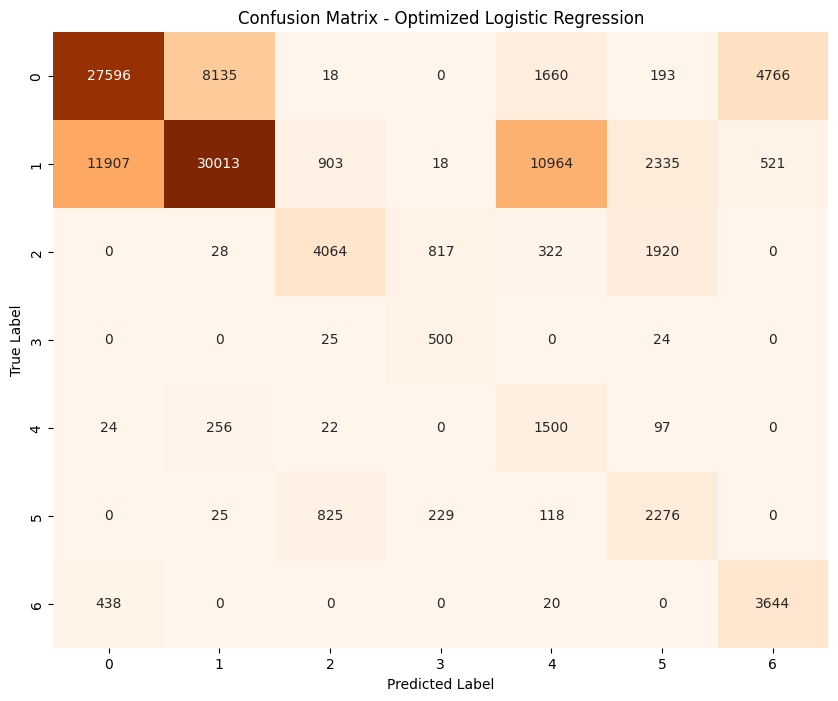

In [12]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Confusion Matrix - Optimized Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()